# Image Preprocessing and Feature Extraction
Data preprocessing is important task in any computer vision. To get precise results, some
background noise should be removed before extraction of features. 
*   So first the RGB image is converted to greyscale
*   Gaussian filter is used for smoothening of the
image
*   Otsu’s thresholding algorithm is implemented to binaries the image
*   Morphological transform is applied on binarised image to close the small holes in the
foreground part
*  The bitwise AND operation on
binarised image and original color image is performed to get RGB image of segmented
leaf
*  Now after image segmentation shape, texture and color features are extracted from
the image. By using contours, area of the leaf and perimeter of the leaf is calculated.
Contours are the line that joins all the points along the edges of objects having same
color or intensity. Mean and standard deviation of each channel in RGB image is also
estimated.
*   To obtain amount of green color in the image, image is first converted to
HSV color space and we have calculated the ratio of number of pixels having pixel
intensity of hue (H) channel in between 30 and 70 and total number of pixels in one
channel. Non green part of image is calculated by subtracting green color part from 1.

After extracting color features from the image, we have extracted texture features from
grey level co-occurrence matrix (GLCM) of the image

GLCM is the spacial relationship of pixels in the image. Extracting texture features
from GCLM is one of the tradition method in computer vision. We have extracted
following features from GCLM:
*   Contrast
*   Dissimilarity
*   Homogeneity
*   Energy
*   Correlation

After extracting all the features from all the images in the dataset, feature selection task
is performed.

<img src="https://www.researchgate.net/publication/352643083/figure/fig2/AS:1037428873768962@1624353726703/Steps-for-data-preprocessing-and-feature-extraction.ppm" width="400" height="500">





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join

## Function to Create a new dataframe

In [ ]:
def create_empty_df():
  col = ['area', 'perimeter', 'red_mean', 'green_mean', 'blue_mean', 'f1', 'f2', 'red_std', 'green_std', 'blue_std', 'f4', 'f5', 'f6', 'f7', 'f8', 'label']
  df = pd.DataFrame(columns = col)
  return df

## Function to Extract the features

In [ ]:
from google.colab.patches import cv2_imshow
def feature_extractor(filename):
  '''
  input params:
  filename : path of the file that we want to process

  output params:
  l: feature vector
  '''

  try:
    main_img = cv2.imread(filename)
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB) #converts an input image from one color space to another.
  except:
    return "Invalid"
  
  #Preprocessing

  gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #Grayscale conversion
  blur = cv2.GaussianBlur(gs, (25,25), 0) #Gaussian Filter: convolves the source image with the specified Gaussian kernel
  cv2_imshow(gs)
  ret_otsu, im_bw_otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Otsu's Thresholding
  cv2_imshow(im_bw_otsu)
  kernel = np.ones((25,25), np.uint8)
  closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel) #perform advanced morphological transformations using an erosion and dilation as basic operations.
  
  cv2_imshow(closing)

  #Shape features
  contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  img_countour = cv2.drawContours(img, contours, 0, 255, 2)

  cv2_imshow(img_countour)

  cnt = contours[0]
  M = cv2.moments(cnt)
  area = cv2.contourArea(cnt)
  if area==0:
    return "Invalid"
  perimeter = cv2.arcLength(cnt,True)

  current_frame = main_img
  filtered_image = closing/255

  #Elementwise Multiplication of range bounded filtered_image with current_frame
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image) #B channel
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image) #G channel
  current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image) #R channel

  img = current_frame
  cv2_imshow(img)

  # Color features
  img = img.astype(float)                 # Ep kieu ve dang float de co the chuyen ve dang nan
  img[filtered_image == 0] = np.nan       # Loc bo nhung diem anh mau den ve dang nan
  red_mean = np.nanmean(img[:,:,0])       # Tinh mean cac pixel khac nan o trong anh
  green_mean = np.nanmean(img[:,:,1])
  blue_mean = np.nanmean(img[:,:,2])
  red_std = np.nanstd(img[:,:,0])         # Tinh std cac pixel khac nan o trong anh
  green_std = np.nanstd(img[:,:,1])
  blue_std = np.nanstd(img[:,:,2])  
  
  img = img.astype(np.uint8)             # Ep lai kieu unsigned int 8 cua anh 

  #amt.of green color in the image
  gr = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  boundaries = [([30,0,0],[70,255,255])]
  for (lower, upper) in boundaries:
    mask = cv2.inRange(gr, (36, 0, 0), (70, 255,255))
    ratio_green = cv2.countNonZero(mask)/(img.size/3)
    f1=np.round(ratio_green, 2)

  #amt. of non green part of the image   
  f2=1-f1

  #Texture features using grey level cooccurance matrix
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  g=greycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

  #with the help of glcm find the contrast
  contrast = greycoprops(g, 'contrast')
  f4=contrast[0][0]+contrast[0][1]+contrast[0][2]+contrast[0][3]
  #[0][3] represent no. of times grey level 3 appears at the right of 0

  #with the help of glcm find the dissimilarity 
  dissimilarity = greycoprops(g, prop='dissimilarity')
  f5=dissimilarity[0][0]+dissimilarity[0][1]+dissimilarity[0][2]+dissimilarity[0][3]

  #with the help of glcm find the homogeneity
  homogeneity = greycoprops(g, prop='homogeneity')
  f6=homogeneity[0][0]+homogeneity[0][1]+homogeneity[0][2]+homogeneity[0][3]

  #with the help of glcm find the energy
  energy = greycoprops(g, prop='energy')
  f7=energy[0][0]+energy[0][1]+energy[0][2]+energy[0][3]

  #with the help of glcm find the correlation
  correlation = greycoprops(g,prop= 'correlation')
  f8=correlation[0][0]+correlation[0][1]+correlation[0][2]+correlation[0][3]

  l = [area, perimeter, red_mean, green_mean, blue_mean,
         f1, f2, red_std, green_std, blue_std,
        f4,f5,f6,f7,f8]
  
  return l

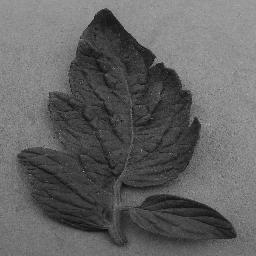

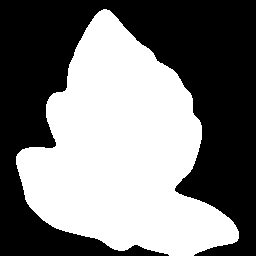

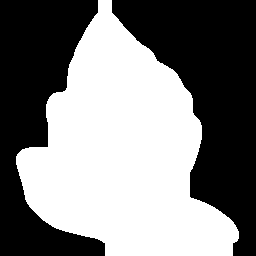

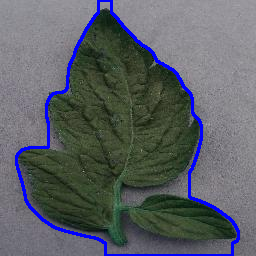

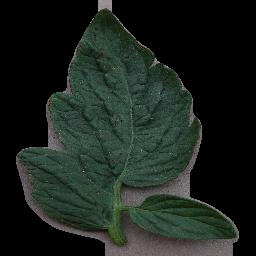

[32308.0,
 847.2691162824631,
 59.11179440110142,
 70.12825455101729,
 53.82309928101576,
 0.16,
 0.84,
 22.248062244151814,
 19.05381247495825,
 24.732375812702724,
 688.9697068435217,
 21.11408376585928,
 2.2410560596132534,
 1.9812148864692039,
 3.7204351581982156]

In [ ]:
feature_extractor('/content/drive/MyDrive/image processing/plantvillage/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG')

## Function to Process one folder

In [ ]:
def process_folder(folderpath, df_f, label_f):
  '''
  input params:
  folderpath : Path of the folder that we want to process
  df_f = dataframe for specific disease
  label_f : label corresponding to the specific disease

  Output params:
  df_f = Dataframe consisting processed vectors
  '''
  imagelist = os.listdir(folderpath) #stores all the imagepaths in the python list
  for image in imagelist:
    imagepath = os.path.join(folderpath, image)
    im_feature = feature_extractor(imagepath)
    if im_feature == "Invalid":
      continue
    im_feature.append(label_f) #append label to feature vector
    df_f.loc[len(df_f)] = im_feature
    if len(df_f)%500 == 0:
      print(len(df_f))

  return df_f

## Function to Process one plant

In [ ]:
def process_plant(folderpaths, labels, savepath):
  '''
  input params:
  folderpaths : List of the folderpaths for specific Plant
  labels : List of labels 
  savepath : Path to export datasheet

  Output params:
  None
  '''
  datasheet = create_empty_df()
  for i in range(len(folderpaths)):
      datasheet = process_folder(folderpaths[i],datasheet,labels[i])

  datasheet.to_excel(savepath)

  return None

## Data Preprocessing


In [ ]:
global_folder = '/content/drive/MyDrive/image processing/plantvillage/'
folderpaths = [global_folder+ 'Tomato___healthy',
              global_folder+ 'Tomato___Bacterial_spot',
              global_folder+ 'Tomato___Early_blight',
              global_folder+ 'Tomato___Late_blight',
              global_folder+ 'Tomato___Leaf_Mold',
              global_folder+ 'Tomato___Septoria_leaf_spot',
              global_folder+'Tomato___Spider_mites Two-spotted_spider_mite',
              global_folder+ 'Tomato___Target_Spot',
              global_folder+'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
              global_folder+ 'Tomato___Tomato_mosaic_virus'
              ]

labels = [0,1,2,3,4,5,6,7,8,9]
savepath = '/content/drive/MyDrive/image processing/processed dataset/tomato_ver2.xlsx'
process_plant(folderpaths, labels, savepath)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000


# Data cleaning and Feature selection
Feature selection is an important step in all machine learning problems. In this project
we are selecting the features on the basis of correlation of variables with target variable.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
raw_data = pd.read_excel('/content/drive/MyDrive/image processing/processed dataset/tomato_ver2.xlsx')

In [ ]:
raw_data.dtypes

index         float64
area          float64
perimeter     float64
red_mean      float64
green_mean    float64
blue_mean     float64
f1            float64
f2            float64
red_std       float64
green_std     float64
blue_std      float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
label         float64
dtype: object

In [ ]:
raw_data.drop(['index'], axis = 1, inplace=True)

In [ ]:
raw_data.columns

Index(['index', 'area', 'perimeter', 'red_mean', 'green_mean', 'blue_mean',
       'f1', 'f2', 'red_std', 'green_std', 'blue_std', 'f4', 'f5', 'f6', 'f7',
       'f8', 'label'],
      dtype='object')

In [ ]:
#Compute pairwise correlation of columns, excluding NA/null values
raw_data.corr()

,area,perimeter,red_mean,green_mean,blue_mean,f1,f2,red_std,green_std,blue_std,f4,f5,f6,f7,f8,label
area,1.000000,0.823961,0.096172,0.064773,0.037474,0.375867,-0.375867,-0.178427,-0.263369,-0.218483,-0.030192,0.141469,-0.585314,-0.624982,0.133278,-0.007656
perimeter,0.823961,1.000000,0.121117,0.077589,0.082238,0.169846,-0.169846,-0.075532,-0.127329,-0.095681,0.036763,0.129931,-0.345969,-0.353278,0.089186,-0.036640
red_mean,0.096172,0.121117,1.000000,0.719708,0.809165,-0.044463,0.044463,0.125401,-0.173209,-0.135450,0.233461,0.272462,-0.394838,-0.364811,0.270689,-0.197789
green_mean,0.064773,0.077589,0.719708,1.000000,0.907308,0.293193,-0.293193,0.196047,-0.091641,-0.104732,0.140712,0.145632,-0.380050,-0.384994,0.458079,0.156171
blue_mean,0.037474,0.082238,0.809165,0.907308,1.000000,0.034756,-0.034756,0.285842,0.002926,-0.008381,0.238218,0.217502,-0.330461,-0.335250,0.331887,0.056597
f1,0.375867,0.169846,-0.044463,0.293193,0.034756,1.000000,-1.000000,0.058095,-0.046800,-0.007901,0.143598,0.291039,-0.614362,-0.595913,0.091853,0.263835
f2,-0.375867,-0.169846,0.044463,-0.293193,-0.034756,-1.000000,1.000000,-0.058095,0.046800,0.007901,-0.143598,-0.291039,0.614362,0.595913,-0.091853,-0.263835
red_std,-0.178427,-0.075532,0.125401,0.196047,0.285842,0.058095,-0.058095,1.000000,0.842272,0.845201,0.735069,0.586771,0.007288,0.087385,-0.539845,0.102148
green_std,-0.263369,-0.127329,-0.173209,-0.091641,0.002926,-0.046800,0.046800,0.842272,1.000000,0.938269,0.718059,0.548914,0.223031,0.320226,-0.684073,0.066848
blue_std,-0.218483,-0.095681,-0.135450,-0.104732,-0.008381,-0.007901,0.007901,0.845201,0.938269,1.000000,0.769089,0.644137,0.120977,0.262089,-0.710742,0.005417


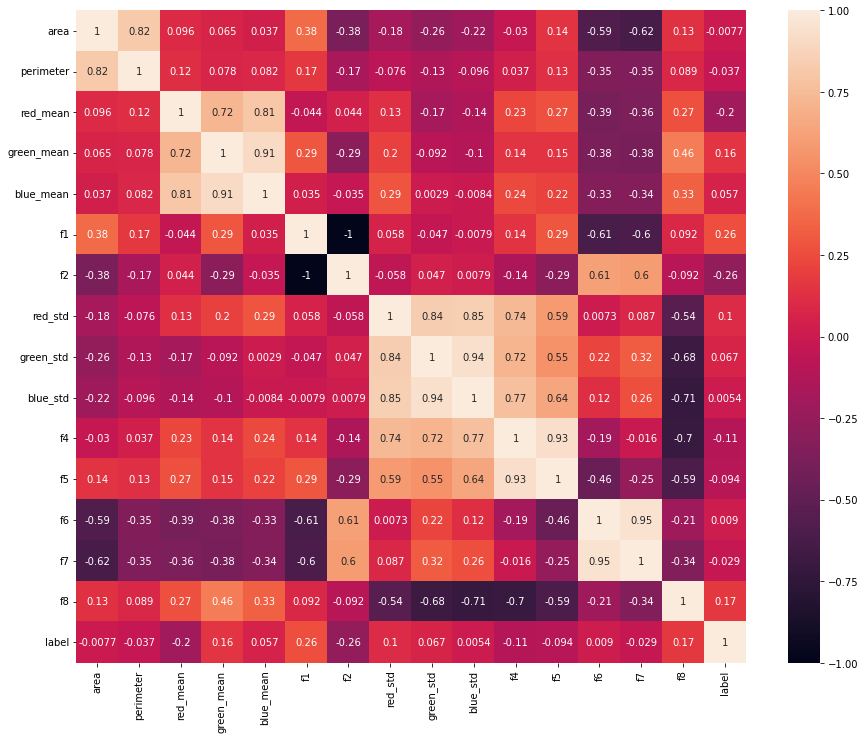

In [ ]:
#Visualize correlation matrix by using heatmap
plt.figure(figsize=(15,12))
sns.heatmap(raw_data.corr(), annot=True)
plt.show()

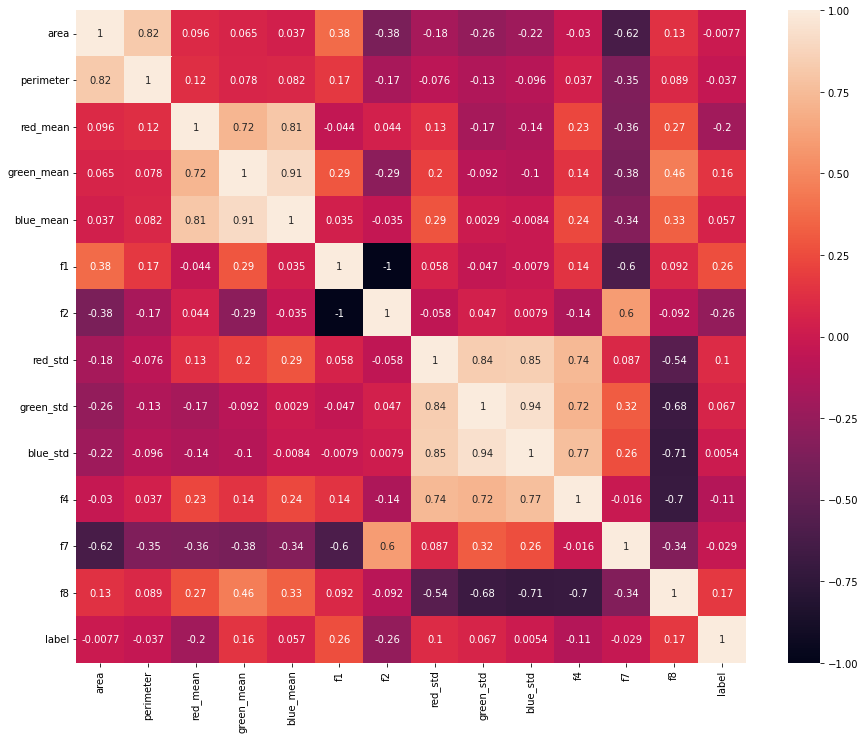

In [ ]:
cleaned_data = raw_data.drop(['f5', 'f6'], axis=1, inplace=False)
#Visualize correlation matrix after drop feature f1
plt.figure(figsize=(15,12))
sns.heatmap(cleaned_data.corr(), annot=True)
plt.show()

In [ ]:
#Remove missing values N/A
cleaned_data = cleaned_data.dropna()
#Shape of raw_data
print('Shape of raw_data: ', raw_data.shape)
#Shape of cleaned_data
print('Shape of cleaned_data: ', cleaned_data.shape)

Shape of raw_data:  (14460, 16)
Shape of cleaned_data:  (14460, 14)


#Implementing classifier and Evaluation

## Using Random forest classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
# import seaborn as sns

In [ ]:
df = cleaned_data.reset_index()

In [ ]:
X = df.drop(['index','label'], axis = 1, inplace=False)
y = df['label']
use_columns = X.columns              # Lay ten cac cot su dung   
X = normalize(X, norm='l2', axis=1)  # Chuan hoa du lieu
print(X.shape)
print(y.shape)

(14460, 13)
(14460,)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


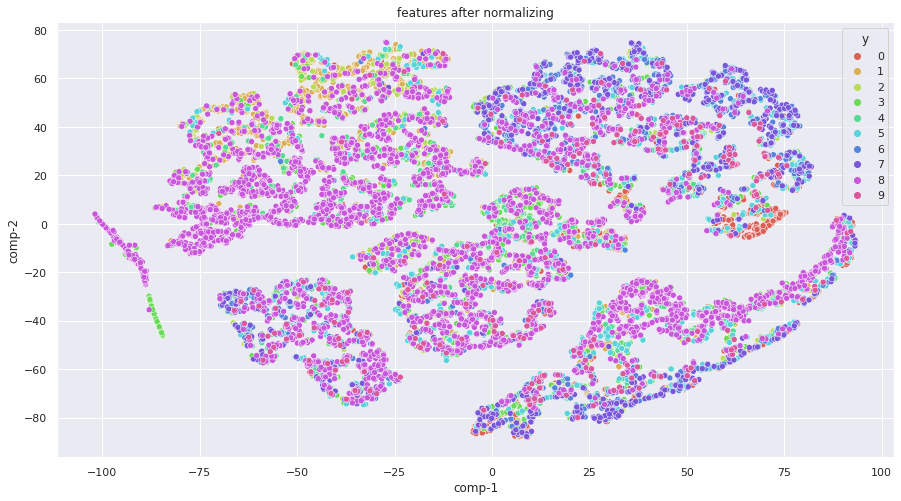

In [ ]:
# Hien thi hoa du lieu
tsne = TSNE(n_components=2)         
z = tsne.fit_transform(X)
dfTSne = pd.DataFrame()
dfTSne['y'] =  y.astype(int)
dfTSne["comp-1"] = z[:,0]
dfTSne["comp-2"] = z[:,1]

sns.set(rc = {'figure.figsize':(15,8)})
sns.scatterplot(x="comp-1", y="comp-2", hue="y",
                palette=sns.color_palette("hls", 10),
                data=dfTSne).set(title="features after normalizing")
plt.show()

In [ ]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 6.8 MB/s 


In [ ]:
# Su dung Gird Search de toi uu cac sieu tham so cua model
import xlsxwriter
model_params = {
    'RF':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10, 12, 15, 17,20, 30, 40, 50, 60, 70],
            'criterion': ['gini','entropy'],
            'max_depth': [5,10,15],
            'max_features': ['auto', 'sqrt', 'log2']
                }
        },
    'SVM':{
        'model': svm.SVC(),
        'params':{
            'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
        }
    }
}
for model_name, mp in model_params.items():
    print(model_name)
    clf = GridSearchCV(mp['model'], mp['params'], cv=5)
    clf.fit(X, y)
    df = pd.DataFrame(clf.cv_results_)
    print("Best Params:", clf.best_params_)
    print("Best Score:", clf.best_score_)
    filepath = '/content/drive/MyDrive/image processing/gridSearch/' + str(model_name) +'.xlsx'
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=model_name)
    writer.save()

RF
Best Params: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 60}
Best Score: 0.7120331950207469
SVM
Best Params: {'C': 40, 'kernel': 'poly'}
Best Score: 0.37136929460580914


In [ ]:
X = pd.DataFrame(X, columns=use_columns)
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)

model = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', n_estimators=60)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]

    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

print(X_train.shape)
print(X_test.shape)
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))

(11568, 13)
(2892, 13)
Score of each fold - [0.7181881051175657, 0.7102351313969572, 0.716804979253112, 0.7060857538035962, 0.7088520055325035]
Avg Score : 0.7120331950207469


###ROC Curve

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


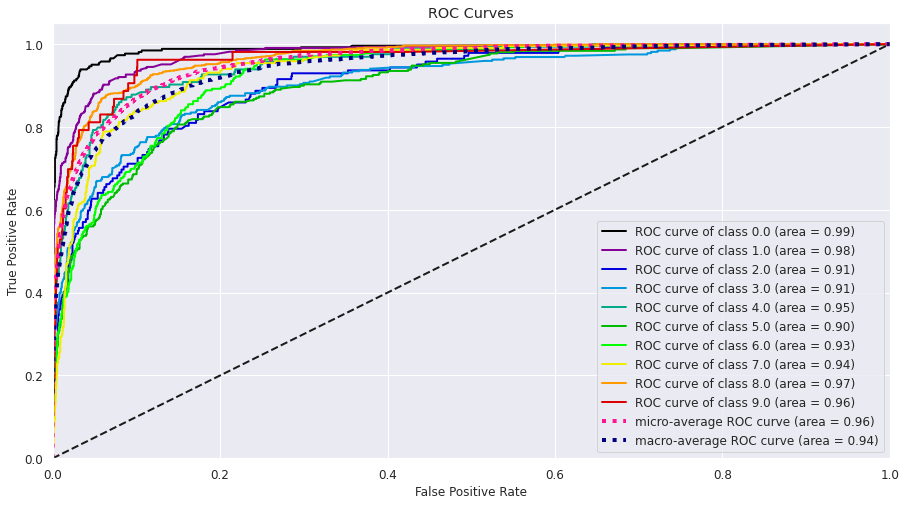

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


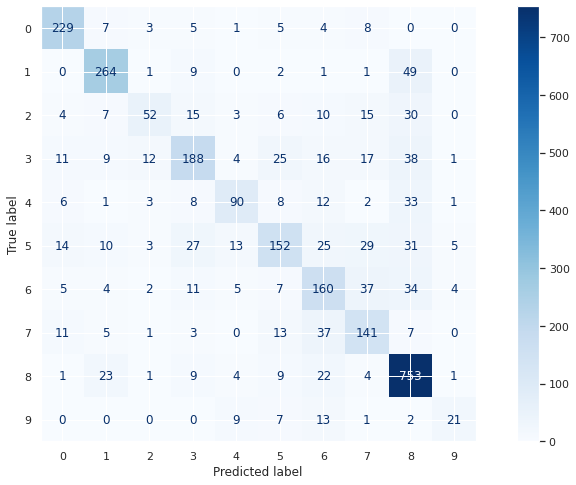

In [ ]:
from sklearn.metrics import plot_confusion_matrix
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test, values_format = 'd',cmap = 'Blues',display_labels = ['0','1','2','3','4','5','6','7','8','9'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9]))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       262
           1       0.80      0.81      0.80       327
           2       0.67      0.37      0.47       142
           3       0.68      0.59      0.63       321
           4       0.70      0.55      0.61       164
           5       0.65      0.49      0.56       309
           6       0.53      0.59      0.56       269
           7       0.55      0.65      0.60       218
           8       0.77      0.91      0.83       827
           9       0.64      0.40      0.49        53

    accuracy                           0.71      2892
   macro avg       0.68      0.62      0.64      2892
weighted avg       0.71      0.71      0.70      2892



**F1 score:**
0.71

###Deployment

In [ ]:
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))

Training Score:  0.9965421853388658


In [ ]:
lm.feature_importances_

array([0.07683218, 0.0520615 , 0.11183929, 0.08398157, 0.07546855,
       0.09917572, 0.05756754, 0.09969924, 0.06630987, 0.06648239,
       0.09371438, 0.05470595, 0.06216182])

In [ ]:
import pickle
filename = '/content/drive/My Drive/Colab Notebooks/Project_Subjects/image processing/tomato_model.sav'
pickle.dump(lm, open(filename, 'wb'))

filename = '/content/drive/My Drive/Colab Notebooks/Project_Subjects/image processing/tomato_model.sav'
dep_model = pickle.load(open(filename, 'rb'))
print(dep_model.score(X,y))